<a href="https://colab.research.google.com/github/aleksanderandrzejewski/projekt-sieci-neuronowe-blok-energetyczny/blob/master/Projekt_sieci_neuronowe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Przygotowanie środowiska i danych

Wczytywanie danych dotycząch funkcjonowania bloku energetycznego.

##Zaimportowanie bibliotek i pobranie danych

In [0]:
#zaimportowanie potrzebnych bibliotek
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

dane_bloku_energetycznego = pd.read_csv("http://jolagazda.nazwa.pl/dane/5_all.csv", sep=",")
dane_bloku_energetycznego.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

#odrzucenie wierszy o stałych wartościach
minima=dane_bloku_energetycznego.min()
maxima=dane_bloku_energetycznego.max()
minima_maxima = pd.concat([minima, maxima], axis=1)
kolumny_ze_stalymi_wartosciami = []
for indeks, wiersz in minima_maxima.iterrows():
  if wiersz[0]==wiersz[1]: #sprawdzenie czy wartość maksymalna jest równa wartości minimalnej
    kolumny_ze_stalymi_wartosciami.append(indeks)
print("Następujące kolumny ze stałymi wartościami zostały odrzucone:",kolumny_ze_stalymi_wartosciami)
dane_bloku_energetycznego = dane_bloku_energetycznego.drop(kolumny_ze_stalymi_wartosciami, axis=1)


#stworzenie nowych danych wejściowych z już istniejących:

#przekonwertowanie dat w postaci tekstu na daty w postaci obiektu pandas._libs.tslib.Timestamp
dane_bloku_energetycznego.loc[:,"DATA"]= pd.to_datetime(dane_bloku_energetycznego.loc[:,"DATA"])
#obliczenie różnic czasu do poprzedniego i następnego pomiaru w minutach
dane_bloku_energetycznego.loc[:,'DATA_-1'] = (dane_bloku_energetycznego.loc[:,'DATA'].shift()-dane_bloku_energetycznego.loc[:,'DATA'])/pd.Timedelta('1m')
dane_bloku_energetycznego.loc[:,'DATA_+1'] = (dane_bloku_energetycznego.loc[:,'DATA'].shift(periods=-1)-dane_bloku_energetycznego.loc[:,'DATA'])/pd.Timedelta('1m')

#stworzenie kolumny godzina 
dane_bloku_energetycznego.loc[:,"godzina"]=dane_bloku_energetycznego.loc[:,"DATA"].apply(lambda x: x.hour)
#stworzenie wektora binarnego [godzina_0, godzina_1, ... , godzina_23]
lista_godzin=[]
for r in range(24):
  dane_bloku_energetycznego["godzina_%d" % r] = dane_bloku_energetycznego["godzina"].apply(
    lambda x: 1.0 if r==x else 0.0)
  lista_godzin.append("godzina_%d" % r)

#pomieszanie kolejności
dane_bloku_energetycznego = dane_bloku_energetycznego.reindex(np.random.permutation(dane_bloku_energetycznego.index))


#oddzielenie danych do testowania
dane_bloku_energetycznego_wszystko=dane_bloku_energetycznego.copy()
dane_bloku_energetycznego_test=dane_bloku_energetycznego.tail(771)
dane_bloku_energetycznego=dane_bloku_energetycznego.head(3084)


#zdefiniowanie funkcji normalizujących
def zamiana_na_wartosc_binarna(series, wartosc_rozdzelajaca):
  return series.apply(lambda x:(1 if x > wartosc_rozdzelajaca else 0))

def przyciecie_odstajacych(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def skalowanie(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

def normalizowanie_log(series):
  return series.apply(lambda x:math.log(x+1.0))

def  normalizowanie_z_score(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

Następujące kolumny ze stałymi wartościami zostały odrzucone: ['PODG.POW.2_NIE_DZIALA_', 'SYGNAL_ZASILANIA_ODGAZOWYWACZA_', 'KRYTYCZNY_POZIOM_MOCY_', 'ZAW._SIARKI_W_PALIWIE_', 'ZAW._AZOTU_W_PALIWIE_', 'ZAW._WILGOCI_W_PALIWIE_', 'ZAW._POPIOLU_W_PALIWIE_', 'WARTOSC_OPALOWA_PALIWA_', 'ZAW._CZESCI_PALNYCH_W_LOT.POP_', 'KOSZT_TONY_WEGLA_', 'ZAW._CZESCI_PALNYCH_W_ZUZLU_', 'O2-ROZNICA_NA_OPP1_', 'O2-ROZNICA_NA_OPP2_', 'CIEPLO_SPALANIA_WEGLA_', 'STRATA_NIECALKOWITEGO_SPALANIA_', 'STRATA_NIEMIERZALNA_', 'ZNAMIONOWY_NADMIAR_POWIETRZA_', 'PRZECIEK_DO_WYLOTU_WP_', 'ODCHYL_JZC-WTRYSK_DO_SW_', 'ODCHYL_JZC-WTRYSK_DO_PARY_SW_', 'PROJEKTOWY_COSINUS_FI_', 'ODCHYL_JZC-WSPOLCZYNNIK_MOCY_', 'ODCHYL_JZC-WSPOLCZYNNIK_MOCY_.1', 'ODCHYL_JZC-WSPOLCZYNNIK_MOCY_.2', 'STRATA-CZ_PALNE_W_LOT_POPIELE_', 'STRATA-CZ_PALNE_W_ZUZLU_', 'STRATA_FIZYCZNA_W_ZUZLU_', 'ZAWARTOSC_WEGLA_W_PALIWIE_', 'ZAWARTOSC_WODORU_W_PALIWIE_', 'ZAWARTOSC_TLENU_W_PALIWIE_', 'REGENERACJA_WP_STOP_', 'PRZEPL_PARY_DO_ODGAZ_Z_UP_III_', 'SYGNAL_ZASI

##Sprawdzenie danych

In [0]:
#@title sprawdzenie kompletności danych
ilosc_wierszy = len(dane_bloku_energetycznego)
print("Ilość wierszy: ", ilosc_wierszy)

lista_brakow=[]
kolumny=list(dane_bloku_energetycznego)
ilosci = dane_bloku_energetycznego.count()
for kolumna, ilosc in zip(kolumny, ilosci):
  if not ilosc == ilosc_wierszy:
    lista_brakow.append((kolumna,ilosc))
if len(lista_brakow)==0:
  print("W żadnej kolumnie nie ma brakujących wartości")
else:
  print("Ilości wierszy w kolumnach z brakami:")
  print(lista_brakow)


Ilość wierszy:  3084
Ilości wierszy w kolumnach z brakami:
[('DATA_-1', 3083)]


In [0]:
dane_bloku_energetycznego.describe()
#dane_bloku_energetycznego.loc[:,'DATA']

,MOC_NA_GENERATORZE_,MOC_BIERNA_,POTRZEBY_WLASNE-A_,POTRZEBY_WLASNE-B_,PRZEP.PARY_SW_WYLOT_Z_KOTLA_,PRZEPLYW_WODY_ZAS.DO_KOTLA_,TEMP.WODY_ZASIL.PRZED_KOTLEM_,CISN.WODY_ZASIL.PRZED_KOTLEM_,SRED.CISN.PARY_W_WALCZAKU_,O2_PRZED_PODGRZ.WODY_L_,...,godzina_14,godzina_15,godzina_16,godzina_17,godzina_18,godzina_19,godzina_20,godzina_21,godzina_22,godzina_23
count,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,...,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0,3084.0
mean,140.8,100.8,5.0,3.6,430.8,435.4,228.2,13.9,13.7,2.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,28.0,46.6,0.7,0.6,78.4,84.8,8.7,0.4,0.4,0.8,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
min,100.3,-12.8,3.5,1.4,331.5,288.6,161.2,11.0,9.5,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,125.0,61.5,4.5,3.2,385.5,386.1,223.4,13.6,13.5,2.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,129.6,108.6,4.7,3.4,398.9,402.5,225.0,13.7,13.6,2.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,146.2,142.3,5.2,3.9,442.7,448.1,230.6,13.9,13.7,3.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,222.0,182.6,7.5,5.9,673.6,708.1,252.0,16.7,15.1,9.4,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
#@title
#sprawdzenie przerw (w h)
for indeks, deltat in enumerate(dane_bloku_energetycznego['DATA_-1']):
  if abs(deltat)>30: print(indeks, deltat/60)
    

48 -1.0
111 -66.5
561 -80.3333333333
819 -86.5
1125 -56.5
1626 -77.5
1827 -162.333333333
1934 -135.0
3032 -37.5


# Wybieranie danych wejściowych

**Cel:** Stworzenie minimalnego zestawu parametrów, który daje podobne rezulaty co kompletny, duży zestaw parametrów. (leksykon sieci neuronowych, str. 18, Analiza wrażliwości).
Mniejszy zestaw parametrów oznacza mniejszy model, który jest wydajniejszy obliczeniowo i łatwiejszy w eksploatacji.

**2-3 parametry wejściowe**

##Lista potencjalnie przydatnych parametrów

In [0]:
rozwazane_str="""MOC NA GENERATORZE 
SPRAWNOSC BLOKU NETTO 
POZIOM WODY W NARWI 
TEMPERATURA WODY NA ZRZUCIE 
CISNIENIE BAROMETRYCZNE 
TEMPERATURA OTOCZENIA 
SREDNIA KROTNOSC CHLODZENIA 
KROTNOSC CHLODZENIA A 
KROTNOSC CHLODZENIA B 
PRZEP.PARY SW WYLOT Z KOTLA 
PRZEPLYW WODY ZAS.DO KOTLA 
CISNIENIE PARY SWIEZEJ 
CISNIENIE W WALCZAKU 
TEMP PARY NA WYL NP 
TEMP PARY SW PRZED TUR 
TEMP PARY WT PRZED TUR 
KOSZT PRODUKCJI ENERGII 
KOSZT PRODUKCJI ENERGII NETTO 
JZC BRUTTO-BLOK 
JZC NETTO-BLOK 
JEDN ZUZ PALIWA UMOWNEGO NETTO 
JEDN ZUZ PALIWA UMOWNEGO BRUTT 
JZC BRUTTO PRZEZ TURBINE 
JZC NETTO PRZEZ TURBINE 
JEDN ZUZYCIE PARY 
CIEPLO DODANE PRZEZ PZ1 
CIEPLO DODANE PRZEZ PZ2 
CISNIENIE ZA PZ1 (NA TLOCZ) 
CISNIENIE ZA PZ2 (NA TLOCZ) 
CISNIENIE ZA PZ3 (NA TLOCZ) 
TEMP.WODY ZAS.ZA PZ1 
TEMP.WODY ZAS.ZA PZ2 
TEMP.WODY ZAS.ZA PZ3 
PRZEPLYW WODY ZAS.ZA PZ1 
PRZEPLYW WODY ZAS.ZA PZ2 
PRZEPLYW WODY ZAS.ZA PZ3 
CALKOWITY PRZEPL WODY CHLODZ 
PROCENT MOCY NA POTRZ WLASNE 
PRZEPL WODY CHL SKRAPL A-TPRG 
PRZEPL WODY CHL SKRAPL B-TPRG 
TEMP.KONDENSATU W SKRAPL.A 
TEMP.KONDENSATU W SKRAPL.B 
TEMP.KONDENSATU ZA SKRAPL.A 
TEMP.KONDENSATU ZA SKRAPL.B 
PRZEPL WODY CHL DO SKRPL A 
PRZEPL WODY CHL DO SKRPL B 
CISNIENIE W KONDENSATORZE KOA 
CISNIENIE W KONDENSATORZE KOB 
SREDNIE PRZECHL W SKRAPL 
WODA CHL.KO-A WYLOT-TEMP. 
WODA CHL.KO-B WYLOT-TEMP. 
WODA CHL.KO-A WLOT-TEMP. 
WODA CHL.KO-B WLOT-TEMP. 
WSP PRZEJ CIEPLA-SKRPL A
WSP PRZEJ CIEPLA-SKRPL B 
WSP CZYSTOSCI-SKRPL A 
WSP CZYSTOSCI-SKRPL B 
SRED PODGRZ WODY CHL SKRAPL 
PODGRZ WODY CHL SKRAPL A 
PODGRZ WODY CHL SKRAPL B 
SPIETRZENIE TEMP W SPRAPL A 
SPIETRZENIE TEMP W SPRAPL B 
PRZECHL SKROPLIN CT1 
PRZECHL SKROPLIN CT2 
CISNIENIE W SKRAPLACZU 
PRZEPLYW KONDENSATU ZA PK 
PRZEPL WODY ZASIL Z ZWZ 
ENERGIA W PARZE UPUSTOWEJ 
CIS PARY WYLOT WP 
ILOSC WEGLA DO KOTLA 
CIEPLO GENEROWANE W KOTLE 
SPRAWNOSC KOTLA MIERZONA 
PRZEPLYW MASOWY SPALIN 
ZAWARTOSC CO W SPALINACH L 
ZAWARTOSC CO W SPALINACH P """
rozwazane_str=rozwazane_str.replace(' ', '_')
rozwazane=rozwazane_str.splitlines()

##Wizualizacja danych

###histogramy

In [0]:
for indeks in range(len(rozwazane)):
  plt.hist(dane_bloku_energetycznego[rozwazane[indeks]], bins=100)
  plt.savefig(rozwazane[indeks]+'.png')
  plt.xlabel(rozwazane[indeks])
  plt.ylabel('liczba wierszy')
  files.download(rozwazane[indeks]+'.png')
  plt.clf()

"\nfor indeks in range(len(rozwazane)):\n  plt.hist(dane_bloku_energetycznego[rozwazane[indeks]], bins=100)\n  plt.savefig(rozwazane[indeks]+'.png')\n  plt.xlabel(rozwazane[indeks])\n  plt.ylabel('liczba wierszy')\n  files.download(rozwazane[indeks]+'.png')\n  plt.clf()\n"

In [0]:

kolumny = list(dane_bloku_energetycznego)
dl = len(kolumny)

for indeks in range(len(kolumny)):
  if(kolumny[indeks]):
    print(indeks, ' z ' , dl, ': ',  kolumny[indeks])
    try:
      plt.hist(dane_bloku_energetycznego[kolumny[indeks]], bins=100)
      plt.savefig(kolumny[indeks].replace('/', '_')+'.png')
      plt.xlabel(kolumny[indeks])
      plt.ylabel('liczba wierszy')
      files.download(kolumny[indeks].replace('/', '_')+'.png')
      plt.clf()
    except:
      print("Błąd")
     

'\nkolumny = list(dane_bloku_energetycznego)\ndl = len(kolumny)\n\nfor indeks in range(len(kolumny))[137:138]:\n  if(kolumny[indeks]):\n    print(indeks, \' z \' , dl, \': \',  kolumny[indeks])\n    try:\n      plt.hist(dane_bloku_energetycznego[kolumny[indeks]], bins=100)\n      plt.savefig(kolumny[indeks].replace(\'/\', \'_\')+\'.png\')\n      plt.xlabel(kolumny[indeks])\n      plt.ylabel(\'liczba wierszy\')\n      files.download(kolumny[indeks].replace(\'/\', \'_\')+\'.png\')\n      plt.clf()\n    except:\n      print("B\xc5\x82\xc4\x85d")\n'

###histogramy

In [0]:
histogram
dane_bloku_energetycznego['MOC NA GENERATORZE '.replace(' ', '_')].hist(bins=1000)

In [0]:
dane_bloku_energetycznego['POZIOM WODY W NARWI '.replace(' ', '_')].hist(bins=1000)

###wykres od daty

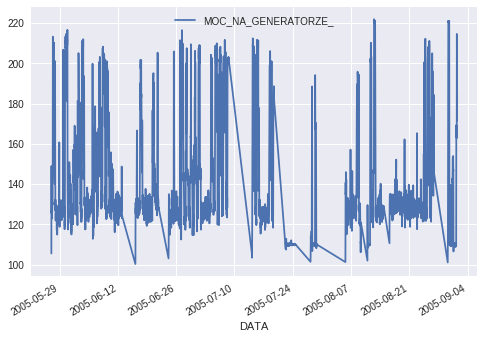

In [0]:
dane_bloku_energetycznego.plot(y='MOC NA GENERATORZE '.replace(' ', '_'), x='DATA')

###Hexbin 

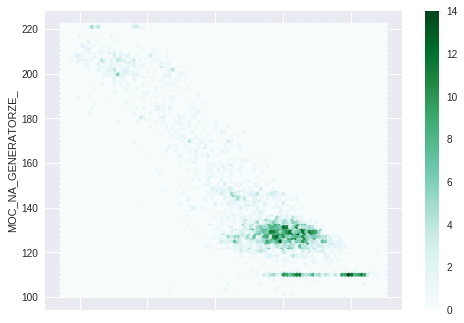

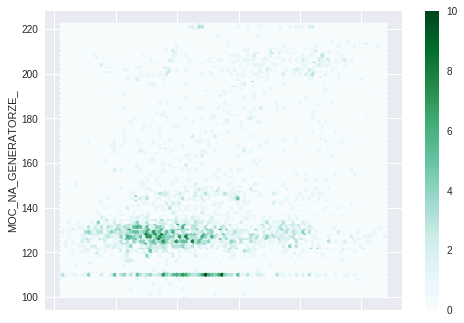

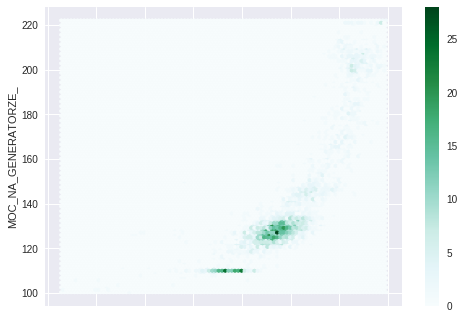

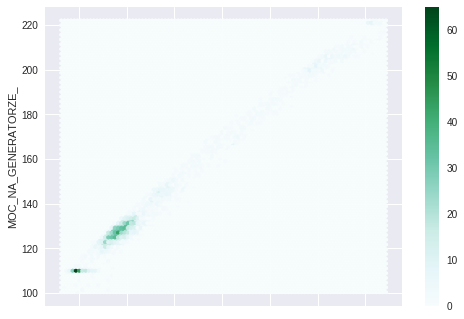

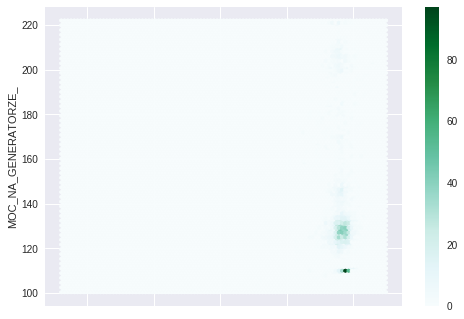

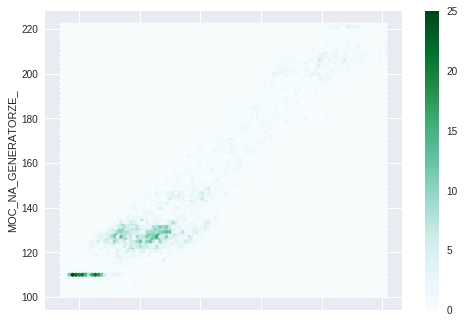

In [0]:
wykres natężenia punktów hexbin


dane_bloku_energetycznego.plot.hexbin(y='MOC NA GENERATORZE '.replace(' ', '_'), x='PRZECHL SKROPLIN CT1 '.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='MOC NA GENERATORZE '.replace(' ', '_'), x='TEMPERATURA OTOCZENIA '.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='MOC NA GENERATORZE '.replace(' ', '_'), x='SPRAWNOSC BLOKU NETTO '.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='MOC NA GENERATORZE '.replace(' ', '_'), x='PRZEP.PARY SW WYLOT Z KOTLA '.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='MOC NA GENERATORZE '.replace(' ', '_'), x='CISNIENIE PARY SWIEZEJ '.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='MOC NA GENERATORZE '.replace(' ', '_'), x='SRED PODGRZ WODY CHL SKRAPL '.replace(' ', '_'))

###Scatter

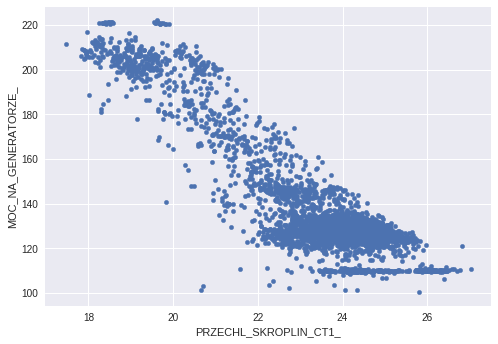

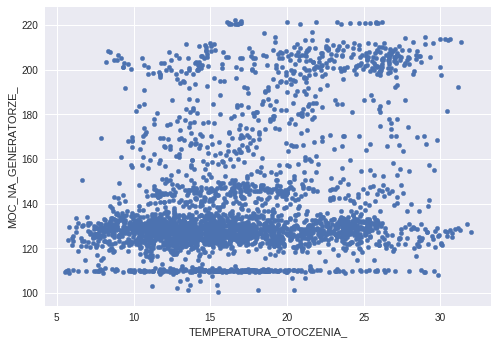

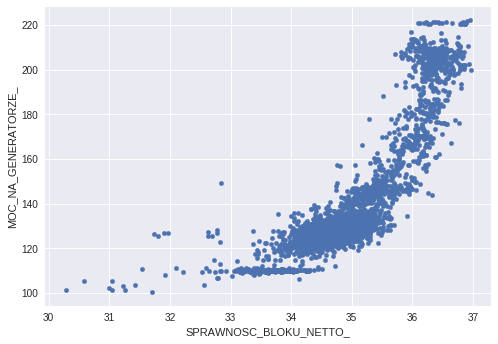

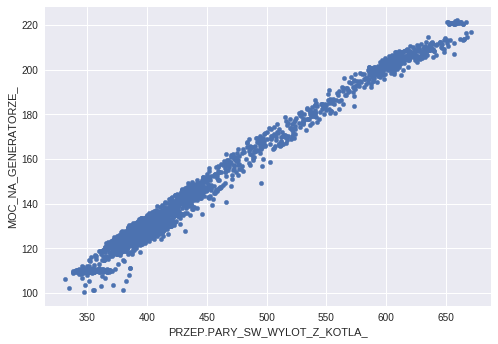

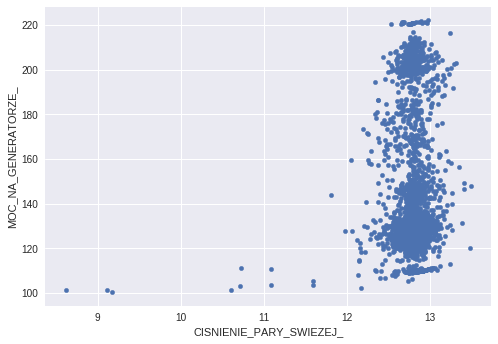

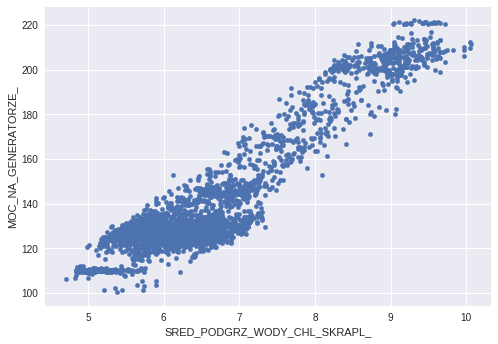

In [0]:
#wykres punktowy

dane_bloku_energetycznego.plot.scatter(y='MOC NA GENERATORZE '.replace(' ', '_'), x='PRZECHL SKROPLIN CT1 '.replace(' ', '_'))
dane_bloku_energetycznego.plot.scatter(y='MOC NA GENERATORZE '.replace(' ', '_'), x='TEMPERATURA OTOCZENIA '.replace(' ', '_'))
dane_bloku_energetycznego.plot.scatter(y='MOC NA GENERATORZE '.replace(' ', '_'), x='SPRAWNOSC BLOKU NETTO '.replace(' ', '_'))
dane_bloku_energetycznego.plot.scatter(y='MOC NA GENERATORZE '.replace(' ', '_'), x='PRZEP.PARY SW WYLOT Z KOTLA '.replace(' ', '_'))
dane_bloku_energetycznego.plot.scatter(y='MOC NA GENERATORZE '.replace(' ', '_'), x='CISNIENIE PARY SWIEZEJ '.replace(' ', '_'))
dane_bloku_energetycznego.plot.scatter(y='MOC NA GENERATORZE '.replace(' ', '_'), x='SRED PODGRZ WODY CHL SKRAPL '.replace(' ', '_'))


###moc vs godzina

In [0]:
dane_bloku_energetycznego.plot.scatter(y='MOC NA GENERATORZE '.replace(' ', '_'), x='godzina'.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='MOC NA GENERATORZE '.replace(' ', '_'), x='godzina'.replace(' ', '_'))

###temp vs godzina

In [0]:
dane_bloku_energetycznego.plot.scatter(y='TEMPERATURA OTOCZENIA '.replace(' ', '_'), x='godzina'.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='TEMPERATURA OTOCZENIA '.replace(' ', '_'), x='godzina'.replace(' ', '_'))

###poziom wody w narwi vs data
ciekawy przypadek odstający

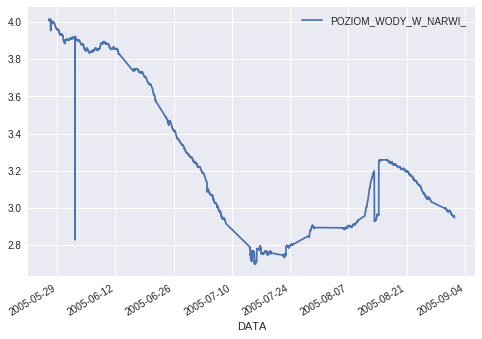

In [0]:
dane_bloku_energetycznego.plot(y='POZIOM WODY W NARWI '.replace(' ', '_'), x='DATA'.replace(' ', '_'))

### **temp vs data**

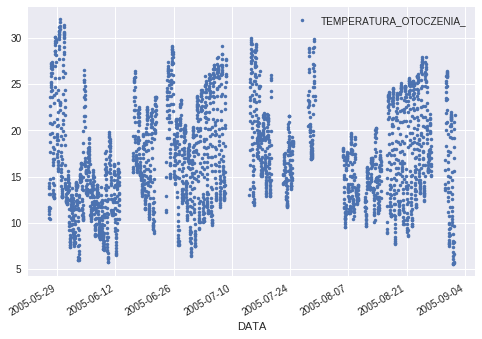

In [0]:
dane_bloku_energetycznego.plot(style=".",y='TEMPERATURA OTOCZENIA '.replace(' ', '_'), x='DATA'.replace(' ', '_'))

###koszt produkcji en netto vs data - outliers po przerwach

In [0]:
dane_bloku_energetycznego.plot(x='DATA'.replace(' ', '_'), y='KOSZT PRODUKCJI ENERGII NETTO '.replace(' ', '_'))
dane_bloku_energetycznego.plot(x='DATA'.replace(' ', '_'), y='KOSZT PRODUKCJI ENERGII NETTO '.replace(' ', '_'))

###temp vs godzina

In [0]:
dane_bloku_energetycznego.plot.scatter(y='TEMPERATURA OTOCZENIA '.replace(' ', '_'), x='godzina'.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='TEMPERATURA OTOCZENIA '.replace(' ', '_'), x='godzina'.replace(' ', '_'))

###wsp czyst skr vs godzina (niemożliwy wynik, nie możliwe żeby były zmiany dobowe)

In [0]:
dane_bloku_energetycznego.plot.scatter(y='WSP CZYSTOSCI-SKRPL A '.replace(' ', '_'), x='godzina'.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='WSP CZYSTOSCI-SKRPL A '.replace(' ', '_'), x='godzina'.replace(' ', '_'))

###temp otoczenia vs temp wody na zrzucie

In [0]:
dane_bloku_energetycznego.plot.scatter(y='TEMPERATURA OTOCZENIA '.replace(' ', '_'), x='TEMPERATURA WODY NA ZRZUCIE '.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='TEMPERATURA OTOCZENIA '.replace(' ', '_'), x='TEMPERATURA WODY NA ZRZUCIE '.replace(' ', '_'))

###temp otoczenia vs temp wody na zrzucie

In [0]:
dane_bloku_energetycznego.plot.scatter(y='MOC NA GENERATORZE '.replace(' ', '_'), x='TEMPERATURA WODY NA ZRZUCIE '.replace(' ', '_'))
dane_bloku_energetycznego.plot.hexbin(y='MOC NA GENERATORZE '.replace(' ', '_'), x='TEMPERATURA WODY NA ZRZUCIE '.replace(' ', '_'))

##Analiza korelacji


Korelacja definiowana jako współczynnik korelacjie Pearsona ( https://pl.wikipedia.org/wiki/Wsp%C3%B3%C5%82czynnik_korelacji_Pearsona ).  

Wartości wspołczynnika korelacji:

  * `-1.0`: idealne ujemna korelacja 
  * `0.0`: brak korelacji
  * `1.0`: idealna dodatnia korelacja
  
  Dane wejściowe powinny być skorelowane z wyjściowymi, ale powinny mieć mały współczynnik korelacji między sobą (tak aby dostarczały niezależnych informacji)


In [0]:

correlation_dataframe1 = przypadki_uczace_wejscie.copy()
correlation_dataframe1["wyjscie"] = przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny]
tabela_korelacji1 = correlation_dataframe1.corr()
display.display(tabela_korelacji1)


NameError: ignored

In [0]:
"""
tabela_korelacji = dane_bloku_energetycznego.corr()
print(tabela_korelacji)
from google.colab import drive
drive.mount('drive')

tabela_korelacji.to_csv('data.csv')
!cp data.csv drive/My\ Drive/
"""

"\ntabela_korelacji = dane_bloku_energetycznego.corr()\nprint(tabela_korelacji)\nfrom google.colab import drive\ndrive.mount('drive')\n\ntabela_korelacji.to_csv('data.csv')\n!cp data.csv drive/My\\ Drive/\n"

#Regresja liniowa

##Obliczenia

In [0]:
#określenie danych wejściowych
dane_wyjsciowe_nazwa_kolumny = "MOC NA GENERATORZE ";
dane_wyjsciowe_nazwa_kolumny=dane_wyjsciowe_nazwa_kolumny.replace(' ', '_')

#określenie danych wyjściowych
wybrane_kolumny_str ="""TEMPERATURA WODY NA ZRZUCIE 
TEMPERATURA OTOCZENIA """
wybrane_kolumny_str=wybrane_kolumny_str.replace(' ', '_')
wybrane_kolumny=wybrane_kolumny_str.splitlines()

wybrane_kolumny+=lista_godzin

In [0]:
def przygotowanie_danych_wejsciowych(wybrane_parametry):
  #skasowanie kolumn poza tymi wybranymi

  dane_bloku_energetycznego_wybrane=wybrane_parametry.loc[:,wybrane_kolumny]
  
  return dane_bloku_energetycznego_wybrane


def przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego):
  dane_wyjsciowe = pd.DataFrame()
  dane_wyjsciowe[dane_wyjsciowe_nazwa_kolumny] = dane_bloku_energetycznego[dane_wyjsciowe_nazwa_kolumny]
  return dane_wyjsciowe

# Wybranie 3084 pierwszych wierszy (z 3855) jako przypadki uczące
przypadki_uczace_wejscie = przygotowanie_danych_wejsciowych(dane_bloku_energetycznego.head(2313))
przypadki_uczace_wyjscie = przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego.head(2313))

# Wybranie 771 ostatnich wierszy (z 3855) jako przypadki służace do walidacji.
przypadki_walidacyjne_wejscie = przygotowanie_danych_wejsciowych(dane_bloku_energetycznego.tail(771))
przypadki_walidacyjne_wyjscie = przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego.tail(771))


# Sprawdzenie podziału
"""
print("Podsumowanie tabeli dane wejściowe uczące:")
display.display(przypadki_uczace_wejscie.describe())
print("Podsumowanie tabeli dane wejściowe walidacyjne:")
display.display(przypadki_walidacyjne_wejscie.describe())

print("Podsumowanie tabeli dane wyjściowe uczące:")
display.display(przypadki_uczace_wyjscie.describe())
print("Podsumowanie tabeli dane wyjściowe walidacyjne:")
display.display(przypadki_walidacyjne_wyjscie.describe())
"""

def stworzenie_kolumn_parametrow_wejsciowych(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])


def funkcja_wejsciowa(features, targets, wielkosc_probki=10, shuffle=True, num_epochs=None):
    #Przekonwertowanie danych typu pandas do słownika (dict) składającego się z tablic np.array
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Stworzenie zbioru danych (dataset) i skonfigurowanie ilości iteracji
    ds = Dataset.from_tensor_slices((features,targets))  
    ds = ds.batch(wielkosc_probki).repeat(num_epochs)

    # Wymieszanie danych
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def train_model(
    wspolczynnik_uczenia,
    steps,
    wielkosc_probki,
    przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie):

  periods = 10
  kroki_iteracyjne_na_okres = steps / periods

  # Zdefiniowanie algorytmu optymalizacji
  algorytm_optymalizacji = tf.train.GradientDescentOptimizer(learning_rate=wspolczynnik_uczenia)
  algorytm_optymalizacji = tf.contrib.estimator.clip_gradients_by_norm(algorytm_optymalizacji, 5.0)
  model_regresji_liniowej = tf.estimator.LinearRegressor(
      feature_columns=stworzenie_kolumn_parametrow_wejsciowych(przypadki_uczace_wejscie),
      optimizer=algorytm_optymalizacji
  )
    
  #Zdefiniowanie funkcji wejściowych
  uczenie_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_uczace_wejscie, 
                                          przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny], 
                                          wielkosc_probki=wielkosc_probki)
  przewidywanie_uczenie_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_uczace_wejscie, 
                                                  przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  przewidywanie_walidacja_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_walidacyjne_wejscie, 
                                                    przypadki_walidacyjne_wyjscie[dane_wyjsciowe_nazwa_kolumny], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Trenowanie modelu w pętli
 
  print("Rozpoczęto uczenie modelu")
  print("Błąd RMSE (dla przypadków uczących):")
  blad_rmse_dla_danych_uczacych = []
  blad_rmse_dla_danych_walidacyjnych = []
  for period in range (0, periods):
    # Wznowienie uczenia modelu począwszy od poprzedniego stanu
    model_regresji_liniowej.train(
        input_fn=uczenie_funkcja_wejsciowa,
        steps=kroki_iteracyjne_na_okres
    )
    # Wyznaczenie przewidywań modelu
    przewidywania_dla_danych_uczacych = model_regresji_liniowej.predict(input_fn=przewidywanie_uczenie_funkcja_wejsciowa)
    przewidywania_dla_danych_uczacych = np.array([element['predictions'][0] for element in przewidywania_dla_danych_uczacych])
    
    przewidywania_dla_danych_walidacyjnych = model_regresji_liniowej.predict(input_fn=przewidywanie_walidacja_funkcja_wejsciowa)
    przewidywania_dla_danych_walidacyjnych = np.array([element['predictions'][0]for element in przewidywania_dla_danych_walidacyjnych])
    
    # Obliczenie błędu dla danych uczących i walidacyjnych
    blad_sredni_kwadratowy_dla_danych_uczacych = math.sqrt(
        metrics.mean_squared_error(przewidywania_dla_danych_uczacych, przypadki_uczace_wyjscie))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(przewidywania_dla_danych_walidacyjnych, przypadki_walidacyjne_wyjscie))
     
    print("  okres %02d : %0.2f" % (period, blad_sredni_kwadratowy_dla_danych_uczacych))
      
    blad_rmse_dla_danych_uczacych.append(blad_sredni_kwadratowy_dla_danych_uczacych)
    blad_rmse_dla_danych_walidacyjnych.append(validation_root_mean_squared_error)
  print("Zakończono uczenie modelu")

  
  # Wygenerowanie wykresu postepu uczenia
  plt.ylabel("RMSE")
  plt.xlabel("Okresy")
  plt.title("RMSE w funkcji numeru okresu")
  plt.tight_layout()
  plt.plot(blad_rmse_dla_danych_uczacych, label="dane treningowe")
  plt.plot(blad_rmse_dla_danych_walidacyjnych, label="dane walidacyjne")
  plt.legend()

  return model_regresji_liniowej

Rozpoczęto uczenie modelu
Błąd RMSE (dla przypadków uczących):
  okres 00 : 120.11
  okres 01 : 97.41
  okres 02 : 75.34
  okres 03 : 54.65
  okres 04 : 37.72
  okres 05 : 31.20
  okres 06 : 31.18
  okres 07 : 31.16
  okres 08 : 31.15
  okres 09 : 31.12
Zakończono uczenie modelu


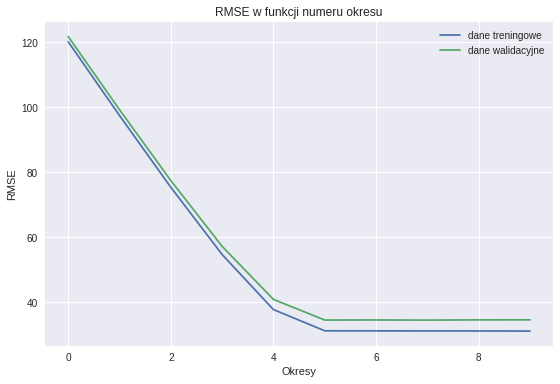

In [0]:
_ = train_model(
    wspolczynnik_uczenia=0.003,
    steps=500,
    wielkosc_probki=20,
    przypadki_uczace_wejscie=przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie=przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie=przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie=przypadki_walidacyjne_wyjscie)

#Klasyfikacja

##Inicjalizacja (dla obu), określenie wejścia i wyjścia

In [0]:
#określenie danych wejściowych
dane_wyjsciowe_nazwa_kolumny = "MOC NA GENERATORZE ";
prog = 140
dane_wyjsciowe_nazwa_kolumny=dane_wyjsciowe_nazwa_kolumny.replace(' ', '_')

#określenie danych wyjściowych
wybrane_kolumny_str ="""POZIOM WODY W NARWI 
CISNIENIE BAROMETRYCZNE 
TEMPERATURA OTOCZENIA 
SREDNIA KROTNOSC CHLODZENIA 
KROTNOSC CHLODZENIA A 
KROTNOSC CHLODZENIA B 
PRZEPLYW WODY ZAS.DO KOTLA 
TEMP.WODY ZAS.ZA PZ1 
TEMP.WODY ZAS.ZA PZ2 
TEMP.WODY ZAS.ZA PZ3 
PRZEPLYW WODY ZAS.ZA PZ1 
PRZEPLYW WODY ZAS.ZA PZ2 
PRZEPLYW WODY ZAS.ZA PZ3 
CALKOWITY PRZEPL WODY CHLODZ 
PRZEPL WODY CHL SKRAPL A-TPRG 
PRZEPL WODY CHL SKRAPL B-TPRG 
TEMP.KONDENSATU W SKRAPL.A 
TEMP.KONDENSATU W SKRAPL.B 
TEMP.KONDENSATU ZA SKRAPL.A 
TEMP.KONDENSATU ZA SKRAPL.B 
CISNIENIE W KONDENSATORZE KOA 
CISNIENIE W KONDENSATORZE KOB 
SREDNIE PRZECHL W SKRAPL 
WODA CHL.KO-A WYLOT-TEMP. 
WODA CHL.KO-B WYLOT-TEMP. 
WODA CHL.KO-A WLOT-TEMP. 
WODA CHL.KO-B WLOT-TEMP. 
WSP PRZEJ CIEPLA-SKRPL A
WSP PRZEJ CIEPLA-SKRPL B 
WSP CZYSTOSCI-SKRPL A 
WSP CZYSTOSCI-SKRPL B 
SPIETRZENIE TEMP W SPRAPL A 
SPIETRZENIE TEMP W SPRAPL B 
PRZECHL SKROPLIN CT1 
PRZECHL SKROPLIN CT2 
CISNIENIE W SKRAPLACZU """
wybrane_kolumny_str=wybrane_kolumny_str.replace(' ', '_')
wybrane_kolumny=wybrane_kolumny_str.splitlines()

#wybrane_kolumny+=lista_godzin

In [0]:
#@title Inicjalizacja
def przygotowanie_danych_wejsciowych(wybrane_parametry):
  #skasowanie kolumn poza tymi wybranymi
  dane_bloku_energetycznego_wybrane=wybrane_parametry.loc[:,wybrane_kolumny]
  return dane_bloku_energetycznego_wybrane


def przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego):
  dane_wyjsciowe = pd.DataFrame()
  dane_wyjsciowe[dane_wyjsciowe_nazwa_kolumny+'_binarnie'] = (dane_bloku_energetycznego[dane_wyjsciowe_nazwa_kolumny] > prog ).astype(float)
  return dane_wyjsciowe

# Wybranie 3084 pierwszych wierszy (z 3855) jako przypadki uczące
przypadki_uczace_wejscie = przygotowanie_danych_wejsciowych(dane_bloku_energetycznego.head(2313))
przypadki_uczace_wyjscie = przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego.head(2313))

# Wybranie 771 ostatnich wierszy (z 3855) jako przypadki służace do walidacji.
przypadki_walidacyjne_wejscie = przygotowanie_danych_wejsciowych(dane_bloku_energetycznego.tail(771))
przypadki_walidacyjne_wyjscie = przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego.tail(771))


# Sprawdzenie podziału
"""
print("Podsumowanie tabeli dane wejściowe uczące:")
display.display(przypadki_uczace_wejscie.describe())
print("Podsumowanie tabeli dane wejściowe walidacyjne:")
display.display(przypadki_walidacyjne_wejscie.describe())

print("Podsumowanie tabeli dane wyjściowe uczące:")
display.display(przypadki_uczace_wyjscie.describe())
print("Podsumowanie tabeli dane wyjściowe walidacyjne:")
display.display(przypadki_walidacyjne_wyjscie.describe())
"""

def stworzenie_kolumn_parametrow_wejsciowych(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])


def funkcja_wejsciowa(features, targets, wielkosc_probki=10, shuffle=True, num_epochs=None):
    #Przekonwertowanie danych typu pandas do słownika (dict) składającego się z tablic np.array
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Stworzenie zbioru danych (dataset) i skonfigurowanie ilości iteracji
    ds = Dataset.from_tensor_slices((features,targets))  
    ds = ds.batch(wielkosc_probki).repeat(num_epochs)

    # Wymieszanie danych
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


## Klasyfikacja regresją liniową


In [0]:
def uczenie_modelu_regresji_liniowej(
    wspolczynnik_uczenia,
    steps,
    wielkosc_probki,
    przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Argumenty funkcji:
    wspolczynnik_uczenia: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    wielkosc_probki: A non-zero `int`, the batch size.
    przypadki_uczace_wejscie: A `DataFrame` containing one or more columns from
      `dane_bloku_energetycznego` to use as input features for training.
    przypadki_uczace_wyjscie: A `DataFrame` containing exactly one column from
      `dane_bloku_energetycznego` to use as target for training.
    przypadki_walidacyjne_wejscie: A `DataFrame` containing one or more columns from
      `dane_bloku_energetycznego` to use as input features for validation.
    przypadki_walidacyjne_wyjscie: A `DataFrame` containing exactly one column from
      `dane_bloku_energetycznego` to use as target for validation.
      
  Funkcja zwraca:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  kroki_iteracyjne_na_okres = steps / periods

  # Zdefiniowanie algorytmu optymalizacji
  algorytm_optymalizacji = tf.train.GradientDescentOptimizer(learning_rate=wspolczynnik_uczenia)
  algorytm_optymalizacji = tf.contrib.estimator.clip_gradients_by_norm(algorytm_optymalizacji, 5.0)
  model_regresji_liniowej = tf.estimator.LinearRegressor(
      feature_columns=stworzenie_kolumn_parametrow_wejsciowych(przypadki_uczace_wejscie),
      optimizer=algorytm_optymalizacji
  )
    
  #Zdefiniowanie funkcji wejściowych
  uczenie_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_uczace_wejscie, 
                                          przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny+'_binarnie'], 
                                          wielkosc_probki=wielkosc_probki)
  przewidywanie_uczenie_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_uczace_wejscie, 
                                                  przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny+'_binarnie'], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  przewidywanie_walidacja_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_walidacyjne_wejscie, 
                                                    przypadki_walidacyjne_wyjscie[dane_wyjsciowe_nazwa_kolumny+'_binarnie'], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Trenowanie modelu w pętli
 
  print("Rozpoczęto uczenie modelu")
  print("Błąd RMSE (dla przypadków uczących):")
  blad_rmse_dla_danych_uczacych = []
  blad_rmse_dla_danych_walidacyjnych = []
  for period in range (0, periods):
    # Wznowienie uczenia modelu począwszy od poprzedniego stanu
    model_regresji_liniowej.train(
        input_fn=uczenie_funkcja_wejsciowa,
        steps=kroki_iteracyjne_na_okres
    )
    # Wyznaczenie przewidywań modelu
    przewidywania_dla_danych_uczacych = model_regresji_liniowej.predict(input_fn=przewidywanie_uczenie_funkcja_wejsciowa)
    przewidywania_dla_danych_uczacych = np.array([element['predictions'][0]for element in przewidywania_dla_danych_uczacych])
    
    przewidywania_dla_danych_walidacyjnych = model_regresji_liniowej.predict(input_fn=przewidywanie_walidacja_funkcja_wejsciowa)
    przewidywania_dla_danych_walidacyjnych = np.array([element['predictions'][0]for element in przewidywania_dla_danych_walidacyjnych])
    
    # Obliczenie błędu dla danych uczących i walidacyjnych
    blad_sredni_kwadratowy_dla_danych_uczacych = math.sqrt(
        metrics.mean_squared_error(przewidywania_dla_danych_uczacych, przypadki_uczace_wyjscie))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(przewidywania_dla_danych_walidacyjnych, przypadki_walidacyjne_wyjscie))
     
    print("  okres %02d : %0.2f" % (period, blad_sredni_kwadratowy_dla_danych_uczacych))
      
    blad_rmse_dla_danych_uczacych.append(blad_sredni_kwadratowy_dla_danych_uczacych)
    blad_rmse_dla_danych_walidacyjnych.append(validation_root_mean_squared_error)
  print("Zakończono uczenie modelu")

  
  # Wygenerowanie wykresu postepu uczenia
  plt.ylabel("RMSE")
  plt.xlabel("Okresy")
  plt.title("RMSE w funkcji numeru okresu")
  plt.tight_layout()
  plt.plot(blad_rmse_dla_danych_uczacych, label="dane treningowe")
  plt.plot(blad_rmse_dla_danych_walidacyjnych, label="dane walidacyjne")
  plt.legend()

  return model_regresji_liniowej

Rozpoczęto uczenie modelu
Błąd RMSE (dla przypadków uczących):
  okres 00 : 0.63
  okres 01 : 0.65
  okres 02 : 0.74
  okres 03 : 0.77
  okres 04 : 0.81
  okres 05 : 0.84
  okres 06 : 0.90
  okres 07 : 0.96
  okres 08 : 0.99
  okres 09 : 0.99
Zakończono uczenie modelu


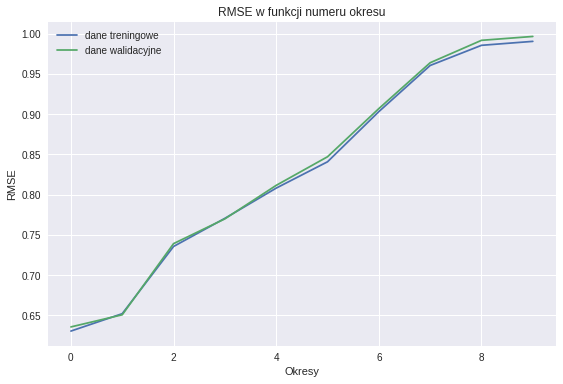

In [0]:
model_regresji_liniowej = uczenie_modelu_regresji_liniowej(
    wspolczynnik_uczenia=0.00003,
    steps=500,
    wielkosc_probki=50,
    przypadki_uczace_wejscie=przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie=przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie=przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie=przypadki_walidacyjne_wyjscie)

Can We Calculate LogLoss for These Predictions?

**Examine the predictions and decide whether or not we can use them to calculate LogLoss.**

`LinearRegressor` uses the L2 loss, which doesn't do a great job at penalizing misclassifications when the output is interpreted as a probability.  For example, there should be a huge difference whether a negative example is classified as positive with a probability of 0.9 vs 0.9999, but L2 loss doesn't strongly differentiate these cases.

In contrast, `LogLoss` penalizes these "confidence errors" much more heavily.  Remember, `LogLoss` is defined as:

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


But first, we'll need to obtain the prediction values. We could use `LinearRegressor.predict` to obtain these.

Given the predictions and the targets, can we calculate `LogLoss`?

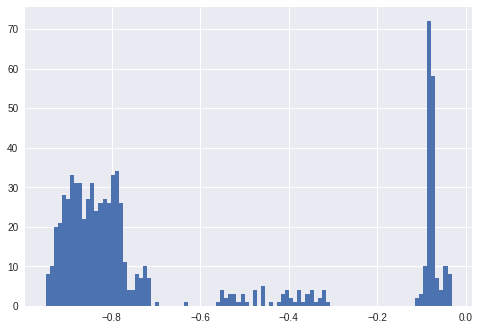

In [0]:
przewidywanie_walidacja_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_walidacyjne_wejscie, 
                                                    przypadki_walidacyjne_wyjscie[dane_wyjsciowe_nazwa_kolumny+'_binarnie'], 
                                                    num_epochs=1, 
                                                    shuffle=False)


przewidywania_dla_danych_walidacyjnych = model_regresji_liniowej.predict(input_fn=przewidywanie_walidacja_funkcja_wejsciowa)
przewidywania_dla_danych_walidacyjnych = np.array([element['predictions'][0] for element in przewidywania_dla_danych_walidacyjnych])

_ = plt.hist(przewidywania_dla_danych_walidacyjnych, bins=100)

{'label/mean': 0.3138781, 'average_loss': 0.9931247, 'global_step': 500, 'prediction/mean': -0.63804173, 'loss': 9.816656}


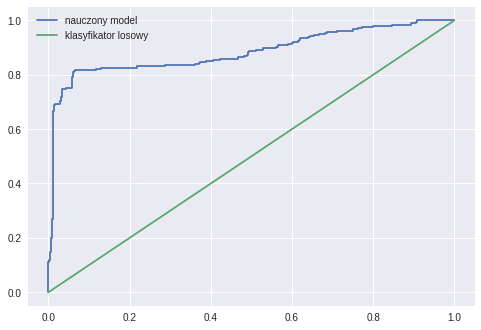

In [0]:
evaluation_metrics = model_regresji_liniowej.evaluate(input_fn=przewidywanie_walidacja_funkcja_wejsciowa)
print(evaluation_metrics)

odsetek_falszywie_pozytywnych, odsetek_prawdziwie_pozytywnych, thresholds = metrics.roc_curve(
    przypadki_walidacyjne_wyjscie, przewidywania_dla_danych_walidacyjnych)
plt.plot(odsetek_falszywie_pozytywnych, odsetek_prawdziwie_pozytywnych, label="nauczony model")
plt.plot([0, 1], [0, 1], label="klasyfikator losowy")
_ = plt.legend(loc=2)

In [0]:
evaluation_metrics

{'average_loss': 0.9931247,
 'global_step': 500,
 'label/mean': 0.3138781,
 'loss': 9.816656,
 'prediction/mean': -0.63804173}

In [0]:
print("Przewidywnia dla danych walidacynych")
print("Prawda: " , np.count_nonzero(True==(przewidywania_dla_danych_walidacyjnych>0.5)) )
print("Fałsz: " , np.count_nonzero(False==(przewidywania_dla_danych_walidacyjnych>0.5)) )

Przewidywnia dla danych walidacynych
Prawda:  0
Fałsz:  771


## Klasyfikacja regresją logistyczną




In [0]:
#@title Trenowanie modelu
def train_linear_classifier_model(
    wspolczynnik_uczenia,
    steps,
    wielkosc_probki,
    przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    wspolczynnik_uczenia: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    wielkosc_probki: A non-zero `int`, the batch size.
    przypadki_uczace_wejscie: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    przypadki_uczace_wyjscie: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    przypadki_walidacyjne_wejscie: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    przypadki_walidacyjne_wyjscie: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  kroki_iteracyjne_na_okres = steps / periods
  
  # Create a linear classifier object.
  algorytm_optymalizacji = tf.train.GradientDescentOptimizer(learning_rate=wspolczynnik_uczenia)
  algorytm_optymalizacji = tf.contrib.estimator.clip_gradients_by_norm(algorytm_optymalizacji, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=stworzenie_kolumn_parametrow_wejsciowych(przypadki_uczace_wejscie),
      optimizer=algorytm_optymalizacji
  )

  #Zdefiniowanie funkcji wejściowych
  uczenie_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_uczace_wejscie, 
                                          przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny+'_binarnie'], 
                                          wielkosc_probki=wielkosc_probki)
  przewidywanie_uczenie_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_uczace_wejscie, 
                                                  przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny+'_binarnie'], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  przewidywanie_walidacja_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_walidacyjne_wejscie, 
                                                    przypadki_walidacyjne_wyjscie[dane_wyjsciowe_nazwa_kolumny+'_binarnie'], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Trenowanie modelu w pętli
 
  print("Rozpoczęto uczenie modelu")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Wznowienie uczenia modelu począwszy od poprzedniego stanu
    linear_classifier.train(
        input_fn=uczenie_funkcja_wejsciowa,
        steps=kroki_iteracyjne_na_okres
    )
    # Wyznaczenie przewidywań modelu    
    training_probabilities = linear_classifier.predict(input_fn=przewidywanie_uczenie_funkcja_wejsciowa)
    training_probabilities = np.array([element['probabilities'] for element in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=przewidywanie_walidacja_funkcja_wejsciowa)
    validation_probabilities = np.array([element['probabilities'] for element in validation_probabilities])   
    
    training_log_loss = metrics.log_loss(przypadki_uczace_wyjscie, training_probabilities)
    validation_log_loss = metrics.log_loss(przypadki_walidacyjne_wyjscie, validation_probabilities)
     
    print("  okres %02d : %0.2f" % (period, training_log_loss))
      
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Zakończono uczenie modelu")
  
  # Wygenerowanie wykresu postepu uczenia
  plt.ylabel("LogLoss")
  plt.xlabel("Okresy")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="dane treningowe")
  plt.plot(validation_log_losses, label="dane walidacyjne")
  plt.legend()

  return linear_classifier

Rozpoczęto uczenie modelu
LogLoss (on training data):
  okres 00 : 0.38
  okres 01 : 0.38
  okres 02 : 0.36
  okres 03 : 0.35
  okres 04 : 0.36
  okres 05 : 0.36
  okres 06 : 0.35
  okres 07 : 0.39
  okres 08 : 0.35
  okres 09 : 0.35
Zakończono uczenie modelu


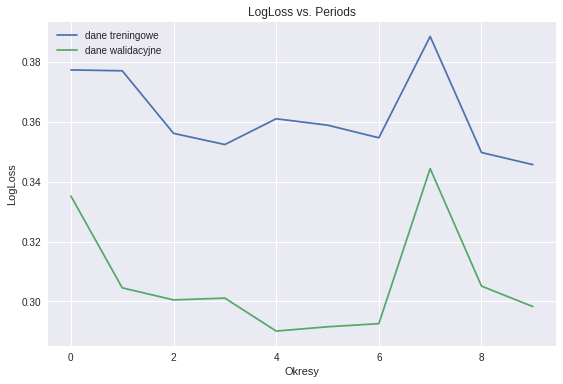

In [0]:
linear_classifier = train_linear_classifier_model(
    wspolczynnik_uczenia=0.000003, #0.000005
    steps=5000, #500 20000
    wielkosc_probki=20, #20 500
    przypadki_uczace_wejscie=przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie=przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie=przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie=przypadki_walidacyjne_wyjscie)


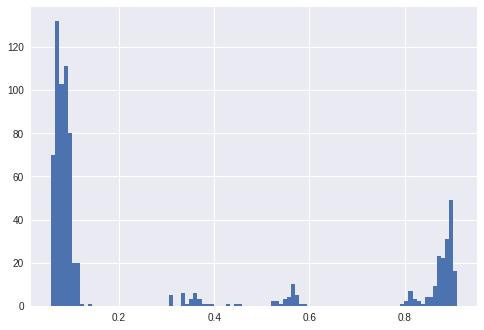

In [0]:
przewidywanie_walidacja_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_walidacyjne_wejscie, 
                                                    przypadki_walidacyjne_wyjscie[dane_wyjsciowe_nazwa_kolumny+'_binarnie'], 
                                                    num_epochs=1, 
                                                    shuffle=False)


validation_probabilities = linear_classifier.predict(input_fn=przewidywanie_walidacja_funkcja_wejsciowa)
validation_probabilities = np.array([element['probabilities'][1] for element in validation_probabilities])

_ = plt.hist(validation_probabilities, bins=100)

Wartość AUC dla przypadków walidacyjnych: 0.90
Precyzja dla przypadków walidacyjnych: 0.89
{'loss': 2.9484522, 'accuracy_baseline': 0.68612194, 'global_step': 5000, 'recall': 0.75206614, 'auc': 0.9023809, 'prediction/mean': 0.29025635, 'precision': 0.8965517, 'label/mean': 0.3138781, 'average_loss': 0.298287, 'auc_precision_recall': 0.88436174, 'accuracy': 0.8949416}


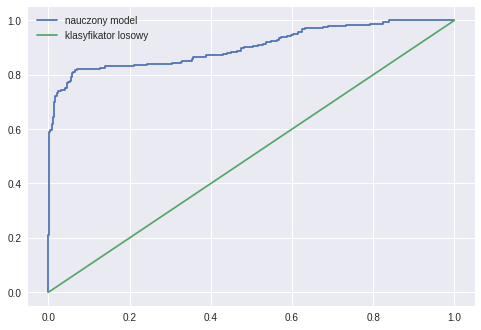

In [0]:
evaluation_metrics = linear_classifier.evaluate(input_fn=przewidywanie_walidacja_funkcja_wejsciowa)
print("Wartość AUC dla przypadków walidacyjnych: %0.2f" % evaluation_metrics['auc'])
print("Precyzja dla przypadków walidacyjnych: %0.2f" % evaluation_metrics['accuracy'])
print(evaluation_metrics)

odsetek_falszywie_pozytywnych, odsetek_prawdziwie_pozytywnych, thresholds = metrics.roc_curve(
    przypadki_walidacyjne_wyjscie, validation_probabilities)
plt.plot(odsetek_falszywie_pozytywnych, odsetek_prawdziwie_pozytywnych, label="nauczony model")
plt.plot([0, 1], [0, 1], label="klasyfikator losowy")
_ = plt.legend(loc=2)

In [0]:
print("Przewidywnia dla danych walidacynych")
print("Prawda: " , np.count_nonzero(True==(validation_probabilities>0.50)) )
print("Fałsz: " , np.count_nonzero(False==(validation_probabilities>0.50)) )

Przewidywnia dla danych walidacynych
Prawda:  203
Fałsz:  568


# Sieci neuronowe z normalizacją

## Obliczenia

In [0]:
##ustawienia ogólne

#określenie danych wejściowych
dane_wyjsciowe_nazwa_kolumny = "MOC NA GENERATORZE ";

#określenie danych wyjściowych
wybrane_kolumny_str ="""POZIOM WODY W NARWI 
CISNIENIE BAROMETRYCZNE 
TEMPERATURA OTOCZENIA 
SREDNIA KROTNOSC CHLODZENIA 
KROTNOSC CHLODZENIA A 
KROTNOSC CHLODZENIA B 
PRZEPLYW WODY ZAS.DO KOTLA 
TEMP.WODY ZAS.ZA PZ1 
TEMP.WODY ZAS.ZA PZ2 
TEMP.WODY ZAS.ZA PZ3 
PRZEPLYW WODY ZAS.ZA PZ1 
PRZEPLYW WODY ZAS.ZA PZ2 
PRZEPLYW WODY ZAS.ZA PZ3 
CALKOWITY PRZEPL WODY CHLODZ 
PRZEPL WODY CHL SKRAPL A-TPRG 
PRZEPL WODY CHL SKRAPL B-TPRG 
TEMP.KONDENSATU W SKRAPL.A 
TEMP.KONDENSATU W SKRAPL.B 
TEMP.KONDENSATU ZA SKRAPL.A 
TEMP.KONDENSATU ZA SKRAPL.B 
CISNIENIE W KONDENSATORZE KOA 
CISNIENIE W KONDENSATORZE KOB 
SREDNIE PRZECHL W SKRAPL 
WODA CHL.KO-A WYLOT-TEMP. 
WODA CHL.KO-B WYLOT-TEMP. 
WODA CHL.KO-A WLOT-TEMP. 
WODA CHL.KO-B WLOT-TEMP. 
WSP PRZEJ CIEPLA-SKRPL A
WSP PRZEJ CIEPLA-SKRPL B 
WSP CZYSTOSCI-SKRPL A 
WSP CZYSTOSCI-SKRPL B 
SPIETRZENIE TEMP W SPRAPL A 
SPIETRZENIE TEMP W SPRAPL B 
PRZECHL SKROPLIN CT1 
PRZECHL SKROPLIN CT2 
CISNIENIE W SKRAPLACZU 
PRZEPLYW MASOWY SPALIN 
ZAWARTOSC CO W SPALINACH L 
ZAWARTOSC CO W SPALINACH P """

wybrane_kolumny_binarne = []
wybrane_kolumny_binarne+=lista_godzin

wspolczynnik_uczenia=0.01
steps=500
wielkosc_probki=10

dane_wyjsciowe_nazwa_kolumny=dane_wyjsciowe_nazwa_kolumny.replace(' ', '_')
wybrane_kolumny_str=wybrane_kolumny_str.replace(' ', '_')
wybrane_kolumny=wybrane_kolumny_str.splitlines()

##ustawienia właściwe dla sieci neuronowych:

ukryte_warstwy=[10, 2]

def normalizowanie_danych_wejsciowych(wybrane_parametry):
  dane_bloku_energetycznego_wybrane = pd.DataFrame()
  
  #normalizownaie kolumn:
  #dane_bloku_energetycznego_wybrane["parametr".replace(' ', '_')] = skalowanie(przyciecie_odstajacych(wybrane_parametry["parametr".replace(' ', '_')], 0, 10000))  
   
  
  #normalizowanie poprzez skalowanie liniowe pozostalych kolumn
  pozostale_kolumny = set(wybrane_kolumny) - set(list(dane_bloku_energetycznego_wybrane))
  for kolumna in pozostale_kolumny:
    dane_bloku_energetycznego_wybrane[kolumna]=skalowanie(wybrane_parametry.loc[:,kolumna])

    #dodanie parametrów binarnych bez normalizowania:
  for kolumna in wybrane_kolumny_binarne:
    dane_bloku_energetycznego_wybrane[kolumna]=wybrane_parametry.loc[:,kolumna]
    
  return dane_bloku_energetycznego_wybrane


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Współczynnik uczenia:  0.01
Liczba kroków iteracji:  500
Wielkość próbki:  10
Ukryte warstwy:  [10, 2]
Rozpoczęto uczenie modelu
Błąd RMSE (dla przypadków uczących):
  okres 00 : 137.85
  okres 01 : 98.19
  okres 02 : 35.93
  okres 03 : 12.28
  okres 04 : 9.68
  okres 05 : 8.86
  okres 06 : 8.07
  okres 07 : 7.71
  okres 08 : 7.36
  okres 09 : 6.98
Zakończono uczenie modelu
Błąd RMSE (dla przypadków uczących) po zakończeniu uczenia:   6.98
Błąd RMSE (dla przypadków walidacyjnych) po zakończeniu uczenia: 7.15


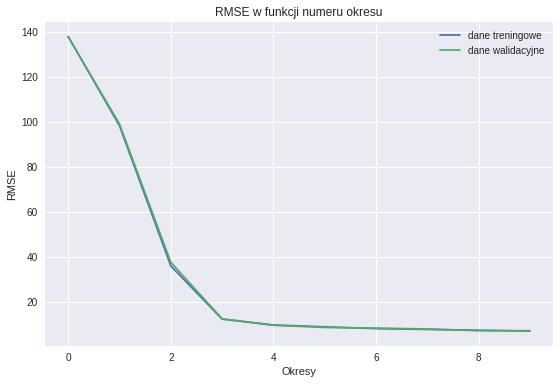

In [0]:
#@title Trenowanie modelu
def przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego):
  dane_wyjsciowe = pd.DataFrame()
  dane_wyjsciowe[dane_wyjsciowe_nazwa_kolumny] = dane_bloku_energetycznego[dane_wyjsciowe_nazwa_kolumny]
  return dane_wyjsciowe

# Wybranie 3084 pierwszych wierszy (z 3855) jako przypadki uczące
przypadki_uczace_wejscie = normalizowanie_danych_wejsciowych(dane_bloku_energetycznego.head(2313))
przypadki_uczace_wyjscie = przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego.head(2313))

# Wybranie 771 ostatnich wierszy (z 3855) jako przypadki służace do walidacji.
przypadki_walidacyjne_wejscie = normalizowanie_danych_wejsciowych(dane_bloku_energetycznego.tail(771))
przypadki_walidacyjne_wyjscie = przygotowanie_danych_wyjsciowych(dane_bloku_energetycznego.tail(771))



# Sprawdzenie podziału
"""
print("Podsumowanie tabeli dane wejściowe uczące:")
display.display(przypadki_uczace_wejscie.describe())
print("Podsumowanie tabeli dane wejściowe walidacyjne:")
display.display(przypadki_walidacyjne_wejscie.describe())

print("Podsumowanie tabeli dane wyjściowe uczące:")
display.display(przypadki_uczace_wyjscie.describe())
print("Podsumowanie tabeli dane wyjściowe walidacyjne:")
display.display(przypadki_walidacyjne_wyjscie.describe())
"""

def stworzenie_kolumn_parametrow_wejsciowych(input_features): 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])


def funkcja_wejsciowa(features, targets, wielkosc_probki=10, shuffle=True, num_epochs=None):
    #Przekonwertowanie danych typu pandas do słownika (dict) składającego się z tablic np.array
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Stworzenie zbioru danych (dataset) i skonfigurowanie ilości iteracji
    ds = Dataset.from_tensor_slices((features,targets))  
    ds = ds.batch(wielkosc_probki).repeat(num_epochs)

    # Wymieszanie danych
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
  
def uczenie_sieci_neuronowej(
    wspolczynnik_uczenia,
    steps,
    wielkosc_probki,
    ukryte_warstwy,
    przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie):

  periods = 10
  kroki_iteracyjne_na_okres = steps / periods
  
  # Określenie algorytmu optymalizacji
  algorytm_optymalizacji = tf.train.GradientDescentOptimizer(learning_rate=wspolczynnik_uczenia)
  algorytm_optymalizacji = tf.contrib.estimator.clip_gradients_by_norm(algorytm_optymalizacji, 5.0)
  siec_neuronowa = tf.estimator.DNNRegressor(
      feature_columns=stworzenie_kolumn_parametrow_wejsciowych(przypadki_uczace_wejscie),
      hidden_units=ukryte_warstwy,
      optimizer=algorytm_optymalizacji,
  )
  
  #Zdefiniowanie funkcji wejściowych
  uczenie_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_uczace_wejscie, 
                                          przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny], 
                                          wielkosc_probki=wielkosc_probki)
  przewidywanie_uczenie_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_uczace_wejscie, 
                                                  przypadki_uczace_wyjscie[dane_wyjsciowe_nazwa_kolumny], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  przewidywanie_walidacja_funkcja_wejsciowa = lambda: funkcja_wejsciowa(przypadki_walidacyjne_wejscie, 
                                                    przypadki_walidacyjne_wyjscie[dane_wyjsciowe_nazwa_kolumny], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Trenowanie modelu w pętli
  print('Współczynnik uczenia: ',wspolczynnik_uczenia)
  print('Liczba kroków iteracji: ',steps)
  print('Wielkość próbki: ',wielkosc_probki)
  print('Ukryte warstwy: ',ukryte_warstwy)
 
  print("Rozpoczęto uczenie modelu")
  print("Błąd RMSE (dla przypadków uczących):")
  blad_rmse_dla_danych_uczacych = []
  blad_rmse_dla_danych_walidacyjnych = []
  for period in range (0, periods):
    # Wznowienie uczenia modelu począwszy od poprzedniego stanu
    siec_neuronowa.train(
        input_fn=uczenie_funkcja_wejsciowa,
        steps=kroki_iteracyjne_na_okres
    )
    # Wyznaczenie przewidywań modelu
    przewidywania_dla_danych_uczacych = siec_neuronowa.predict(input_fn=przewidywanie_uczenie_funkcja_wejsciowa)
    przewidywania_dla_danych_uczacych = np.array([element['predictions'][0] for element in przewidywania_dla_danych_uczacych])
    
    przewidywania_dla_danych_walidacyjnych = siec_neuronowa.predict(input_fn=przewidywanie_walidacja_funkcja_wejsciowa)
    przewidywania_dla_danych_walidacyjnych = np.array([element['predictions'][0] for element in przewidywania_dla_danych_walidacyjnych])
    
    # Obliczenie błędu dla danych uczących i walidacyjnych
    blad_sredni_kwadratowy_dla_danych_uczacych = math.sqrt(
        metrics.mean_squared_error(przewidywania_dla_danych_uczacych, przypadki_uczace_wyjscie))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(przewidywania_dla_danych_walidacyjnych, przypadki_walidacyjne_wyjscie))
     
    print("  okres %02d : %0.2f" % (period, blad_sredni_kwadratowy_dla_danych_uczacych))
      
    blad_rmse_dla_danych_uczacych.append(blad_sredni_kwadratowy_dla_danych_uczacych)
    blad_rmse_dla_danych_walidacyjnych.append(validation_root_mean_squared_error)
  print("Zakończono uczenie modelu")

  # Wygenerowanie wykresu postepu uczenia
  plt.ylabel("RMSE")
  plt.xlabel("Okresy")
  plt.title("RMSE w funkcji numeru okresu")
  plt.tight_layout()
  plt.plot(blad_rmse_dla_danych_uczacych, label="dane treningowe")
  plt.plot(blad_rmse_dla_danych_walidacyjnych, label="dane walidacyjne")
  plt.legend()

  print("Błąd RMSE (dla przypadków uczących) po zakończeniu uczenia:   %0.2f" % blad_sredni_kwadratowy_dla_danych_uczacych)
  print("Błąd RMSE (dla przypadków walidacyjnych) po zakończeniu uczenia: %0.2f" % validation_root_mean_squared_error)

  return siec_neuronowa  


siec_neuronowa = uczenie_sieci_neuronowej(
    wspolczynnik_uczenia=wspolczynnik_uczenia,
    steps=steps,
    wielkosc_probki=wielkosc_probki,
    ukryte_warstwy=ukryte_warstwy,
    przypadki_uczace_wejscie=przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie=przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie=przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie=przypadki_walidacyjne_wyjscie)

In [0]:
"""
siec_neuronowa = uczenie_sieci_neuronowej(
    wspolczynnik_uczenia=0.005,
    steps=2000,
    wielkosc_probki=100,
    ukryte_warstwy=[10, 10],
    przypadki_uczace_wejscie=przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie=przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie=przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie=przypadki_walidacyjne_wyjscie)
"""    

'\nsiec_neuronowa = uczenie_sieci_neuronowej(\n    wspolczynnik_uczenia=0.005,\n    steps=2000,\n    wielkosc_probki=100,\n    ukryte_warstwy=[10, 10],\n    przypadki_uczace_wejscie=przypadki_uczace_wejscie,\n    przypadki_uczace_wyjscie=przypadki_uczace_wyjscie,\n    przypadki_walidacyjne_wejscie=przypadki_walidacyjne_wejscie,\n    przypadki_walidacyjne_wyjscie=przypadki_walidacyjne_wyjscie)\n'

Współczynnik uczenia:  0.001
Liczba kroków iteracji:  6000
Wielkość próbki:  10
Ukryte warstwy:  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Rozpoczęto uczenie modelu
Błąd RMSE (dla przypadków uczących):
  okres 00 : 73.07
  okres 01 : 11.82
  okres 02 : 8.08
  okres 03 : 6.29
  okres 04 : 5.76
  okres 05 : 4.92
  okres 06 : 4.40
  okres 07 : 4.18
  okres 08 : 4.11
  okres 09 : 3.78
Zakończono uczenie modelu
Błąd RMSE (dla przypadków uczących) po zakończeniu uczenia:   3.78
Błąd RMSE (dla przypadków walidacyjnych) po zakończeniu uczenia: 5.53


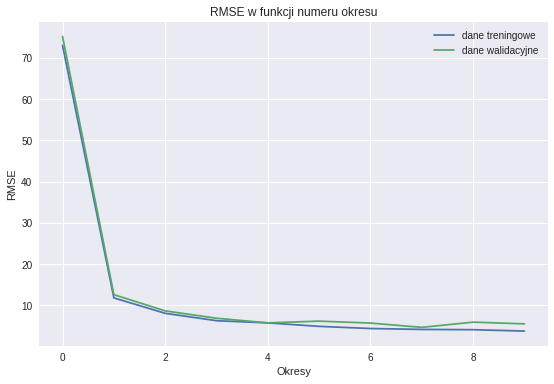

In [0]:

siec_neuronowa = uczenie_sieci_neuronowej(
    wspolczynnik_uczenia=0.001,
    steps=6000,
    wielkosc_probki=10,
    ukryte_warstwy=[50,50,50,50,50,50,50,50,50,50],
    przypadki_uczace_wejscie=przypadki_uczace_wejscie,
    przypadki_uczace_wyjscie=przypadki_uczace_wyjscie,
    przypadki_walidacyjne_wejscie=przypadki_walidacyjne_wejscie,
    przypadki_walidacyjne_wyjscie=przypadki_walidacyjne_wyjscie)
  

In [0]:
#@title podsumowanie tabeli
print("Podsumowanie tabeli dane wejściowe uczące:")
display.display(przypadki_uczace_wejscie.describe())
print("Podsumowanie tabeli dane wejściowe walidacyjne:")
display.display(przypadki_walidacyjne_wejscie.describe())

"""
  Returns a version of the input `DataFrame` that has all its features normalized.
  processed_features = pd.DataFrame()

  processed_features["households"] = skalowanie(examples_dataframe["households"])
  processed_features["median_income"] = skalowanie(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = skalowanie(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = skalowanie(examples_dataframe["latitude"])
  processed_features["longitude"] = skalowanie(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = skalowanie(examples_dataframe["housing_median_age"])

  processed_features["population"] = skalowanie(przyciecie_odstajacych(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = skalowanie(przyciecie_odstajacych(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = skalowanie(przyciecie_odstajacych(examples_dataframe["total_rooms"], 0, 10000))

def zamiana_na_wartosc_binarna(series, threshold):
def przyciecie_odstajacych(series, clip_to_min, clip_to_max):
def skalowanie(series):
def skalowanie(series):
def  normalizowanie_z_score(series):

"""

Podsumowanie tabeli dane wejściowe uczące:


,CISNIENIE_W_KONDENSATORZE_KOB_,KROTNOSC_CHLODZENIA_A_,SREDNIE_PRZECHL_W_SKRAPL_,CISNIENIE_W_SKRAPLACZU_,TEMPERATURA_OTOCZENIA_,WODA_CHL.KO-A_WYLOT-TEMP._,ZAWARTOSC_CO_W_SPALINACH_L_,PRZEPL_WODY_CHL_SKRAPL_A-TPRG_,PRZEPLYW_WODY_ZAS.ZA_PZ2_,TEMP.KONDENSATU_ZA_SKRAPL.A_,...,godzina_14,godzina_15,godzina_16,godzina_17,godzina_18,godzina_19,godzina_20,godzina_21,godzina_22,godzina_23
count,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,...,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0,2313.0
mean,-0.4,0.1,-0.4,-0.4,-0.1,-0.2,-1.0,-0.6,-0.0,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.3,0.4,0.5,0.3,0.4,0.3,0.2,0.8,0.5,0.3,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.6,-0.1,-0.8,-0.6,-0.5,-0.4,-1.0,-1.0,0.0,-0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-0.4,0.1,-0.5,-0.4,-0.2,-0.2,-1.0,-1.0,0.1,-0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,-0.3,0.3,-0.1,-0.3,0.1,0.0,-1.0,0.1,0.2,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Podsumowanie tabeli dane wejściowe walidacyjne:


,CISNIENIE_W_KONDENSATORZE_KOB_,KROTNOSC_CHLODZENIA_A_,SREDNIE_PRZECHL_W_SKRAPL_,CISNIENIE_W_SKRAPLACZU_,TEMPERATURA_OTOCZENIA_,WODA_CHL.KO-A_WYLOT-TEMP._,ZAWARTOSC_CO_W_SPALINACH_L_,PRZEPL_WODY_CHL_SKRAPL_A-TPRG_,PRZEPLYW_WODY_ZAS.ZA_PZ2_,TEMP.KONDENSATU_ZA_SKRAPL.A_,...,godzina_14,godzina_15,godzina_16,godzina_17,godzina_18,godzina_19,godzina_20,godzina_21,godzina_22,godzina_23
count,771.0,771.0,771.0,771.0,771.0,771.0,771.0,771.0,771.0,771.0,...,771.0,771.0,771.0,771.0,771.0,771.0,771.0,771.0,771.0,771.0
mean,-0.3,0.1,-0.5,-0.4,-0.1,-0.1,-1.0,-0.6,0.0,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.3,0.4,0.4,0.3,0.4,0.3,0.2,0.8,0.6,0.3,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.5,-0.1,-0.8,-0.6,-0.4,-0.4,-1.0,-1.0,0.1,-0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-0.4,0.2,-0.6,-0.4,-0.2,-0.2,-1.0,-1.0,0.2,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,-0.2,0.4,-0.3,-0.2,0.2,0.1,-1.0,0.2,0.3,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


'\n  Returns a version of the input `DataFrame` that has all its features normalized.\n  processed_features = pd.DataFrame()\n\n  processed_features["households"] = skalowanie(examples_dataframe["households"])\n  processed_features["median_income"] = skalowanie(examples_dataframe["median_income"])\n  processed_features["total_bedrooms"] = skalowanie(examples_dataframe["total_bedrooms"])\n  \n  processed_features["latitude"] = skalowanie(examples_dataframe["latitude"])\n  processed_features["longitude"] = skalowanie(examples_dataframe["longitude"])\n  processed_features["housing_median_age"] = skalowanie(examples_dataframe["housing_median_age"])\n\n  processed_features["population"] = skalowanie(przyciecie_odstajacych(examples_dataframe["population"], 0, 5000))\n  processed_features["rooms_per_person"] = skalowanie(przyciecie_odstajacych(examples_dataframe["rooms_per_person"], 0, 5))\n  processed_features["total_rooms"] = skalowanie(przyciecie_odstajacych(examples_dataframe["total_rooms